In [37]:
%matplotlib inline

In [38]:
import fipy as fp

In [39]:
from fipy import numerix as nmx

In [40]:
from scipy import fftpack

In [124]:
nx = 128

In [125]:
Lx = 15.

In [126]:
mesh = fp.Grid3D(nx=nx, ny=nx, nz=nx, Lx=Lx, Ly=Lx, Lz=Lx)

In [127]:
dX = fp.CellVariable(mesh=mesh, name=r"$\delta X$")

In [128]:
rp = 1.4

In [129]:
dX.setValue(1., where=(mesh.x - Lx / 2.)**2 + (mesh.y - Lx / 2.)**2 + (mesh.z - Lx / 2.)**2 <= rp**2)

In [130]:
fp.VTKCellViewer(vars=dX).plot(filename="dX2.vtk")

In [48]:
f = fp.openPOSFile("dX.pos", mode='w')

In [49]:
f.write(dX)

In [50]:
f.close()

In [51]:
fp.TSVViewer(vars=dX).plot(filename="dX.csv")

## reciprocal lattice vector

In [131]:
g = fp.CellVariable(mesh=mesh, name=r"$\vec{g}$", rank=1)

In [132]:
g.value.shape = (-1, g.mesh.nx, g.mesh.nx, g.mesh.nx)

In [133]:
g.value[0] = nmx.fft.fftfreq(n=mesh.nx, d=mesh.dx)

In [134]:
g.value[1] = nmx.fft.fftfreq(n=mesh.nx, d=mesh.dx)[..., nmx.newaxis]

In [135]:
g.value[2] = nmx.fft.fftfreq(n=mesh.nx, d=mesh.dx)[..., nmx.newaxis, nmx.newaxis]

In [136]:
g.value.shape = (-1, g.mesh.numberOfCells)

In [137]:
C11 = 280e9
C12 = 120e9
C44 = (C11 - C12)/2.

$\begin{align*}
C_{11} = C_{22} = C_{33} &\rightarrow C_{1111} = C_{2222} = C_{3333} \\
C_{12} = C_{21} = C_{13} = C_{31} = C_{23} = C_{32} &\rightarrow 
C_{1122} = C_{2211} = C_{1133} = C_{3311} = C_{2233} = C_{3322} \\
C_{44} = C_{55} = C_{66} 
&\rightarrow C_{2323} = C_{3232} = C_{2332} = C_{3223} \\
&\quad = C_{1313} = C_{3131} = C_{1331} = C_{3113} \\
&\quad = C_{1212} = C_{2121} = C_{1221} = C_{2112}
\end{align*}$

In [138]:
C = nmx.zeros((3, 3, 3, 3))

In [139]:
C[0][0][0][0] = C[1][1][1][1] = C[2][2][2][2] = C11
C[0][0][1][1] = C[1][1][0][0] = C[0][0][2][2] = C[2][2][0][0] = C[1][1][2][2] = C[2][2][1][1] = C12
C[1][2][1][2] = C[2][1][2][1] = C[1][2][2][1] = C[2][1][1][2] = C44
C[0][2][0][2] = C[2][0][2][0] = C[0][2][2][0] = C[2][0][0][2] = C44
C[0][1][0][1] = C[1][0][1][0] = C[0][1][1][0] = C[1][0][0][1] = C44

In [140]:
Gik_inv = nmx.einsum('ijkl,j...,l...->ik...', C, g.value, g.value)

In [141]:
Gik_inv[..., 0] = nmx.eye(3,3)

In [142]:
Gik = nmx.rollaxis(nmx.array(map(nmx.linalg.inv, nmx.rollaxis(Gik_inv, axis=2))), axis=0, start=3) 

In [143]:
epsilon0 = 0.01

In [144]:
eigenstrain = epsilon0 * nmx.eye(3,3)

In [145]:
eigenstress = nmx.einsum('ijkl...,kl...->ij...', C, eigenstrain)

In [146]:
dXg = fftpack.fftn(dX.value.reshape((nx, nx, nx))).reshape(-1)

In [147]:
ug = -1j * nmx.einsum('ik...,j...,ij...->k...', Gik, g, eigenstress) * dXg

In [148]:
straing = 0.5j * (nmx.einsum('i...,j...->ij...', ug, g) + nmx.einsum('j...,i...->ij...', ug, g))

In [149]:
strain = fftpack.ifftn(straing.reshape((3, 3, nx, nx, nx)), axes=(2,3, 4)).reshape((3, 3, -1))

In [150]:
stress = nmx.einsum('ijkl...,kl...->ij...', C, strain - eigenstrain[..., nmx.newaxis] * dX.value)

In [75]:
fp.VTKCellViewer(vars=fp.CellVariable(mesh=mesh, name=r"\sigma", value=stress, rank=2)).plot(filename="sigma.vtk")

AssertionError: Only arrays of dimensionality 2 or lower are allowed!

In [76]:
%debug

> /Users/guyer/anaconda/envs/parallel/lib/python2.7/site-packages/tvtk/array_handler.py(262)array2vtk()
    260     shape = z.shape
    261     assert len(shape) < 3, \
--> 262            "Only arrays of dimensionality 2 or lower are allowed!"
    263     assert not numpy.issubdtype(z.dtype, complex), \
    264            "Complex numpy arrays cannot be converted to vtk arrays."\

ipdb> u
> /Users/guyer/anaconda/envs/parallel/lib/python2.7/site-packages/tvtk/array_handler.py(651)convert_array()
    649                 vtk_arr = getattr(vtk, vtk_typ)()
    650             except TypeError: # vtk_typ == 'vtkDataArray'
--> 651                 return array2vtk(arr)
    652             else:
    653                 return array2vtk(arr, vtk_arr)

ipdb> u
> /Users/guyer/anaconda/envs/parallel/lib/python2.7/site-packages/tvtk/array_handler.py(765)deref_array()
    763         for a, s in zip(args, sig):
    764             if is_array(a) and is_array_sig(s):
--> 765                 ret.append

In [82]:
import pyvtk

In [151]:
vtk = pyvtk.VtkData(pyvtk.RectilinearGrid(x=nmx.cumsum([0.]+[mesh.dx]*mesh.nx),
                                          y=nmx.cumsum([0.]+[mesh.dy]*mesh.ny),
                                          z=nmx.cumsum([0.]+[mesh.dz]*mesh.nz)))

	Using header='Really cool data'
	No data defined


In [112]:
# vtk = pyvtk.VtkData(pyvtk.StructuredGrid((mesh.nx + 1, mesh.ny + 1, mesh.nz + 1), 
#                                         nmx.rollaxis(mesh.vertexCoords, axis=1)))

	Using header='Really cool data'
	No data defined


In [152]:
vtk.cell_data.append(pyvtk.Scalars(dX.value, name=dX.name))

	Using lookup_table='default'


In [153]:
vtk.cell_data.append(pyvtk.Tensors(nmx.rollaxis(stress.real, axis=2), name=r"$\sigma$"))

In [154]:
vtk.tofile('bypyvtk')

In [34]:
mesh1D = fp.Grid1D(nx=mesh.nx, Lx=Lx)

In [35]:
halfx = mesh.x[nx//2]

In [57]:
sigma11_analytical = fp.CellVariable(mesh=mesh1D, name=r"$\sigma_{11}^{analytical}$", value=0.)

In [64]:
sigma33_analytical = fp.CellVariable(mesh=mesh1D, name=r"$\sigma_{33}^{analytical}$", value=0.)

In [65]:
nu = 0.3

In [66]:
sigma0 = (2./3) * (C11 + 2 * C12) * (1 - 2*nu) / (1 - nu) * epsilon0

In [60]:
sigma11_analytical.setValue(-sigma0, where=(mesh1D.x - Lx/2.)**2 <= rp**2)

In [67]:
sigma33_analytical.setValue(-sigma0, where=(mesh1D.x - Lx/2.)**2 <= rp**2)

In [62]:
sigma11_analytical.setValue(-sigma0 * (rp / abs(mesh1D.x - Lx/2.))**3, where=(mesh1D.x - Lx/2.)**2 > rp**2)

In [68]:
sigma33_analytical.setValue((1./2) * sigma0 * (rp / abs(mesh1D.x - Lx/2.))**3, where=(mesh1D.x - Lx/2.)**2 > rp**2)

ValueError: setting an array element with a sequence.

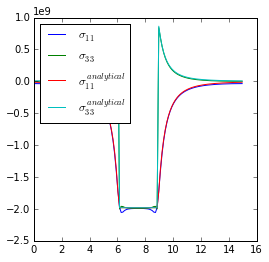

In [69]:
fp.Viewer(vars=(fp.CellVariable(mesh=mesh1D, name=r"$\sigma_{11}$", value=stress[0][0][((mesh.y == halfx) & (mesh.z == halfx)).value]),
                fp.CellVariable(mesh=mesh1D, name=r"$\sigma_{33}$", value=stress[2][2][((mesh.y == halfx) & (mesh.z == halfx)).value]),
                sigma11_analytical, sigma33_analytical))

In [70]:
-(4./3) * C44 * (3*C12 + 2*C44) / (C12 + 2*C44) * epsilon0

-1980952380.9523811

In [71]:
sigma0

1980952380.9523811

ValueError: setting an array element with a sequence.

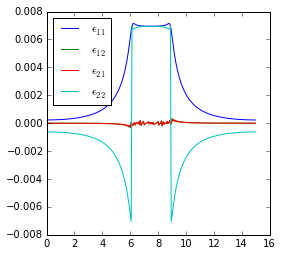

In [553]:
fp.Viewer(vars=(fp.CellVariable(mesh=mesh1D, name=r"$\epsilon_{11}$", value=strain[0][0][(mesh.x == halfx).value]),
                fp.CellVariable(mesh=mesh1D, name=r"$\epsilon_{12}$", value=strain[0][1][(mesh.x == halfx).value]),
                fp.CellVariable(mesh=mesh1D, name=r"$\epsilon_{21}$", value=strain[1][0][(mesh.x == halfx).value]),
                fp.CellVariable(mesh=mesh1D, name=r"$\epsilon_{22}$", value=strain[1][1][(mesh.x == halfx).value])))

In [550]:
strain0 = strain.copy()

In [551]:
stress0 = stress.copy()

In [ ]:
ug = -1j * nmx.einsum('ik...,j...,ij...->k...', Gik, g, eigenstress) * dXg